# Finite Markov Decision Processes

Finite because the state and actions are discrete. Markovian because state depends only on the previous state + action pair. 

In [1]:
from enum import IntEnum

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import gymnasium as gym
from gymnasium import spaces

## Q-Learning / Sarsa & Double Q-Learning

In [89]:
def one_of_best(values, available_actions=None):
    if available_actions is None:
        return np.random.choice(np.where(values==np.max(values))[0])
    argmaxes = np.where(values==np.max(values[available_actions]))[0]
    return np.random.choice(argmaxes[np.isin(argmaxes, available_actions)])

class QLearning:
    def __init__(self, env, alpha, eps, s_dims, a_dim, sarsa=False, gamma=1):
        # I added the env as an argument as a convenience to track state dependent number of actions. 
        # You could pass the method instead if you don't want to code against a gym class.
        self.env = env
        self.alpha = alpha
        self.eps = eps
        self.a_dim = a_dim
        self.q = np.zeros(s_dims + [a_dim])
        self.sarsa = sarsa
        self.gamma = gamma

    def init_episode(self, init_s, init_a):
        self.s = init_s
        self.a = init_a

    def sample(self, state):
        if np.random.rand() > self.eps:
            return one_of_best(self.q[*state], 
                               np.arange(self.env.action_space.n))
        return np.random.choice(self.env.action_space.n)

    def update(self, reward, n_state):
        if self.sarsa:
            n_action = self.sample(n_state)
            next_q = self.q[*n_state, n_action]
        else:
            next_q = np.max(self.q[*n_state])
        self.q[*self.s, self.a] += self.alpha*(reward + self.gamma*next_q - self.q[*self.s, self.a])
        self.s = n_state
        if self.sarsa:
            self.a = n_action
        else:
            self.a = self.sample(n_state)

In [56]:
class DQLearning:
    def __init__(self, env, alpha, eps, s_dims, a_dim, gamma=1):
        self.env = env
        self.alpha = alpha
        self.eps = eps
        self.a_dim = a_dim
        self.q1 = np.zeros(s_dims + [a_dim])
        self.q2 = np.zeros(s_dims + [a_dim])
        self.gamma = gamma

    def init_episode(self, init_s, init_a):
        self.s = init_s
        self.a = init_a

    def sample(self, state):
        if np.random.rand() > self.eps:
            return one_of_best(self.q1[*state] + self.q2[*state], 
                               np.arange(self.env.action_space.n))
        return np.random.choice(self.env.action_space.n)

    def update(self, reward, n_state):
        if np.random.rand() >= 0.5:
            a = one_of_best(self.q1[*n_state], 
                            np.arange(self.env.action_space.n))
            self.q1[*self.s, self.a] += self.alpha*(reward 
                                                    + self.gamma*self.q2[*n_state, a]
                                                    - self.q1[*self.s, self.a])
        else:
            a = one_of_best(self.q2[*n_state], 
                            np.arange(self.env.action_space.n))
            self.q2[*self.s, self.a] += self.alpha*(reward 
                                                    + self.gamma*self.q1[*n_state, a]
                                                    - self.q2[*self.s, self.a])
        self.s = n_state
        self.a = self.sample(n_state)

In [4]:
def print_opt_policy(q, start, finish):
    dims = q.shape[:-1]
    for i in range(0, dims[0]):
        print('\n')
        for j in range(0, dims[1]):
            if [i, j] == start:
                print(' 0 ', end="")
                continue
            if [i, j] == finish:
                print(' * ', end="")
                continue
            bestAction = np.argmax(q[i, j, :])
            if bestAction == Action.N:
                print(' ↑ ', end="")
            elif bestAction == Action.S:
                print(' ↓ ', end="")
            elif bestAction == Action.W:
                print(' ← ', end="")
            elif bestAction == Action.E:
                print(' → ', end="")

## First a simple discrete observation space, Windy Grid World from eg. 6.5

In [8]:
class Action(IntEnum):
    N = 0
    S = 1
    W = 2
    E = 3

class WindyGridworld(gym.Env):
    def __init__(self):
        self.dims = [7, 10]
        
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
                spaces.Discrete(self.dims[0]),
                spaces.Discrete(self.dims[1])
                ))
        self.start = [3, 0]
        self.goal = [3, 7]
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

        self.reset()

    def step(self, action):
        """
        Returns: observation, reward, terminated, truncated, info
        """
        self.t += 1
        i, j = self.S

        if action == Action.S:
            i  = max(min(i + 1 - self.wind[j], self.dims[0] - 1), 0)
        elif action == Action.N:
            i = max(i - 1 - self.wind[j], 0)
        elif action in [Action.W, Action.E]:
            i = max(i - self.wind[j], 0)
            if action == Action.E:
                j = min(j + 1, self.dims[1] - 1)
            elif action == Action.W:
                j = max(j - 1, 0)

        self.S = [i, j]
        return self.S, -1, self.S == self.goal, False, {}

    def reset(self):
        self.S = self.start
        self.t = 0
        return self.S, {}

In [81]:
env = WindyGridworld()
observation = env.reset()
dims = [o.n for o in env.observation_space]

In [78]:
np.random.seed(seed=123456789)

n = 200 

ts = np.zeros(n)
algo = QLearning(env, 0.5, 0.1, dims, env.action_space.n)
for i in range(n):
    observation, info = env.reset()
    action = algo.sample(observation)
    algo.init_episode(observation, action)
    t = 1
    while True:
        observation, reward, terminated, truncated, info = env.step(algo.a)
        algo.update(reward, observation)
        if terminated:
            break
        t += 1
    ts[i] = t

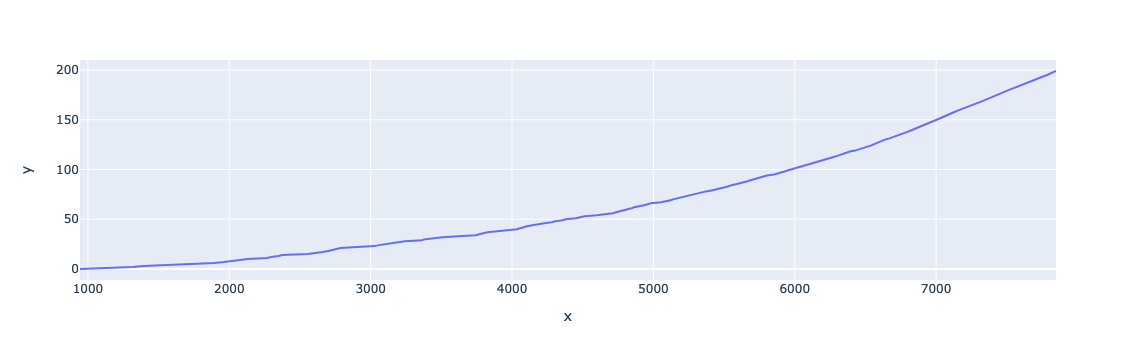

In [79]:
px.line(x=np.cumsum(ts), y=np.arange(n))

In [80]:
## visualize optimal move for windy grid world: follow the arrows from 0 to * but imagine the wind lifting you
## upward!
print(env.wind)
print_opt_policy(algo.q, env.start, env.goal)

[0, 0, 0, 1, 1, 1, 2, 2, 1, 0]


 ↑  →  →  →  →  →  →  →  →  ↓ 

 →  →  →  →  →  →  →  →  →  ↓ 

 ↑  →  →  →  →  →  →  ↑  →  ↓ 

 0  →  →  →  →  →  ↑  *  →  ↓ 

 ←  ↓  →  →  →  →  ↑  ↓  ←  ← 

 ↓  →  ↓  →  →  ↑  ↑  ↑  ←  ↓ 

 →  →  ↓  →  ↑  ↑  ↑  ↑  ↑  ↓ 

## Cliff Walking to illustrate differences between Sarsa and Q-Learning

In [13]:
class CliffWalking(gym.Env):
    def __init__(self):
        self.dims = [4, 12]
        
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
                spaces.Discrete(self.dims[0]),
                spaces.Discrete(self.dims[1])
                ))
        self.start = [0, 0]
        self.goal = [0, 11]

        self.reset()

    def step(self, action):
        """
        Returns: observation, reward, terminated, truncated, info
        """
        self.t += 1
        i, j = self.S

        if action == Action.S:
            i  = min(i + 1, self.dims[0] - 1)
        elif action == Action.N:
            i = max(i - 1, 0)
        if action == Action.E:
            j = min(j + 1, self.dims[1] - 1)
        elif action == Action.W:
            j = max(j - 1, 0)

        self.S = [i, j]
        reward = -100 if (i==0 and 0<j<11) else -1
        return self.S, reward, i==0 and j>0, False, {}

    def reset(self):
        self.S = self.start
        self.t = 0
        return self.S, {}

In [85]:
env = CliffWalking()
observation = env.reset()
dims = [o.n for o in env.observation_space]

In [15]:
np.random.seed(seed=123456789)

runs = 200
n = 200 

r_qlearning = np.zeros((runs, n))
r_sarsa = np.zeros((runs, n))

for j in range(runs):
    algo_q = QLearning(env, 0.5, 0.1, dims, env.action_space.n)
    for i in range(n):
        observation, info = env.reset()
        action = algo_q.sample(observation)
        algo_q.init_episode(observation, action)
        r = 0
        while True:
            observation, reward, terminated, truncated, info = env.step(algo_q.a)
            algo_q.update(reward, observation)
            r += reward
            if terminated:
                break
        r_qlearning[j, i] = r
        
    algo = QLearning(env, 0.5, 0.1, dims, env.action_space.n, sarsa=True)
    for i in range(n):
        observation, info = env.reset()
        action = algo.sample(observation)
        algo.init_episode(observation, action)
        r = 0
        while True:
            observation, reward, terminated, truncated, info = env.step(algo.a)
            algo.update(reward, observation)
            r += reward
            if terminated:
                break
        r_sarsa[j, i] = r

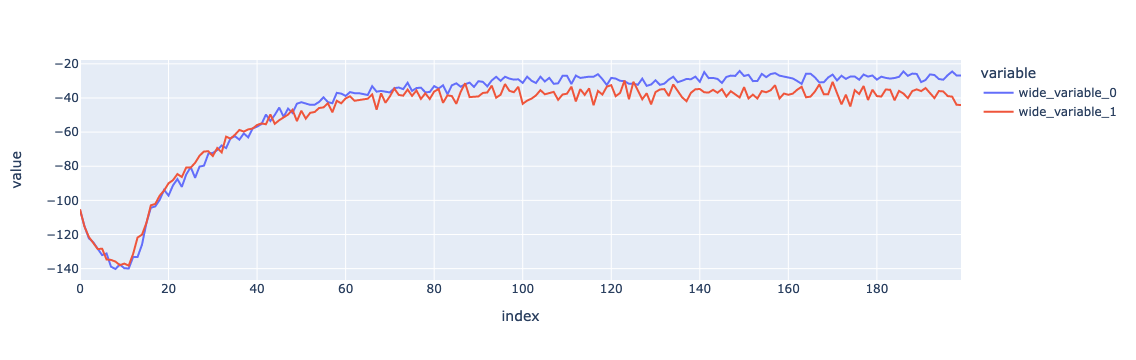

In [16]:
px.line(y=[np.mean(r_sarsa, axis=0), np.mean(r_qlearning, axis=0)])

I don't quite the same drop in rewards for Q-Learning than Sarsa (because Sutton/Barto do not restart episodes after the agent falls off the cliff; their simulation is more Groundhog Day style with the day restarting over and over until the agent gets it right). 

Sarsa generally chooses the safer but longer path (follow the arrows from 0 to *):

In [17]:
print_opt_policy(algo.q, env.start, env.goal)



 0  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  * 

 ↓  ↓  ↓  ↓  ←  ↓  ←  ←  →  →  →  ↑ 

 →  ↓  ↓  →  →  ↓  ↓  ↓  ↓  →  ↑  ↑ 

 →  →  →  →  →  →  →  →  →  ↑  →  ↑ 

In [18]:
print_opt_policy(algo_q.q, env.start, env.goal)



 0  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  * 

 →  →  →  →  →  →  →  →  →  →  →  ↑ 

 →  ↑  →  ↑  →  →  ↑  ↑  →  ↑  ↑  ↑ 

 ←  →  ↑  →  →  →  ↓  ↑  ←  ←  →  ↑ 

## Eg. 6.7 to illustrate bias issues in Q-Learning and the merits of Double Q-Learning

In [87]:
class Action2D(IntEnum):
    R = 0
    L = 1

class MaxBiasEg(gym.Env):
    def __init__(self):
        self.observation_space = spaces.Discrete(13)
        self.start = 0
        self.end = 1  # B = 2; left of B is 3:13
        self._actions = [spaces.Discrete(1) for i in range(13)]
        self._actions[0] = spaces.Discrete(2)
        self._actions[2] = spaces.Discrete(10)
        self.max_action_space_n = 10

        self.reset()

    def step(self, action):
        self.t += 1
        terminated = False
        reward = 0
        if self.S == [0]:
            if action == Action2D.L:
                self.S = [2]
            elif action == Action2D.R:
                self.S = [1]
                terminated = True
                
        elif self.S == [2]:
            self.S = [action + 2]
            reward = np.random.normal(-0.1, 1)
            terminated = True
        return self.S, reward, terminated, False, {}

    @property
    def action_space(self):
        return self._actions[self.S[0]]

    def reset(self):
        self.S = [self.start]
        self.t = 0
        return self.S, {}

In [57]:
np.random.seed(seed=123456789)

env = MaxBiasEg()
dims = [env.observation_space.n]

runs = 1000
n = 300 

ls = np.zeros((runs, n))
dls = np.zeros((runs, n))
for j in range(runs):
    algo = DQLearning(env, 0.1, 0.1, dims, env.max_action_space_n)
    for i in range(n):
        observation, info = env.reset()
        action = algo.sample(observation)
        if action == Action2D.L:
            dls[j, i] = 1
        algo.init_episode(observation, action)
        while True:
            observation, reward, terminated, truncated, info = env.step(action)
            algo.update(reward, observation)
            if terminated:
                break

    algo = QLearning(env, 0.1, 0.1, dims, env.max_action_space_n)
    for i in range(n):
        observation, info = env.reset()
        action = algo.sample(observation)
        if action == Action2D.L:
            ls[j, i] = 1
        algo.init_episode(observation, action)
        while True:
            observation, reward, terminated, truncated, info = env.step(action)
            algo.update(reward, observation)
            if terminated:
                break

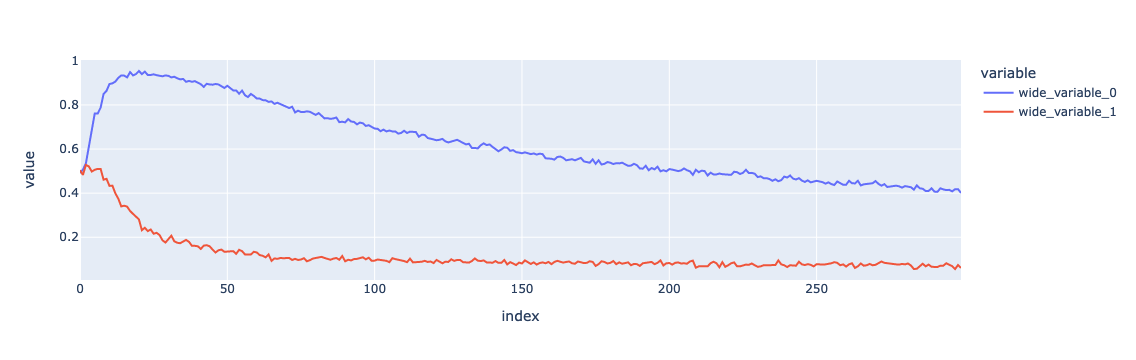

In [58]:
px.line(y=[np.mean(ls, axis=0), np.mean(dls, axis=0)])

## Cart Pole with a continuous action space that must be discretized

In [59]:
env = gym.make("CartPole-v1")
observation, _ = env.reset()

env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

In [60]:
dims = [3, 3, 9, 5]
bins = [
    np.linspace(-2.4, 2.4, dims[0]), 
    np.linspace(-3, 3, dims[1]),
    np.linspace(-.2095, .2095, dims[2]),
    np.linspace(-3, 3, dims[3])
    ]

In [61]:
def _discretize(observation, bins):
    return [np.digitize(o, b) - 1 for o, b in zip(observation, bins)]

In [62]:
_discretize(observation, bins)

[0, 1, 4, 1]

In [73]:
np.random.seed(seed=123456789)

n = 3000

ts = np.zeros(n)
algo = DQLearning(env, 0.25, 0.05, dims, env.action_space.n)
for i in range(n):
    observation, info = env.reset()
    observation = _discretize(observation, bins)
    action = algo.sample(observation)
    algo.init_episode(observation, action)
    t = 1
    while True:
        observation, reward, terminated, truncated, info = env.step(algo.a)
        observation = _discretize(observation, bins)
        algo.update(reward, observation)
        if terminated:
            break
        t += 1
    ts[i] = t

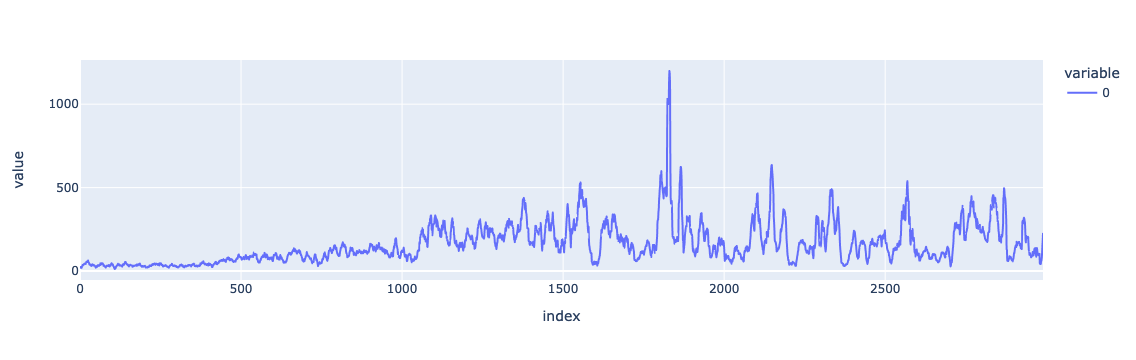

In [74]:
px.line(np.convolve(ts, np.ones(10)/10, "valid"))

In [75]:
## evaluate cart pole with entirely greedy policy
n= 200

algo.eps = 0
ts = np.zeros(n)
for i in range(n):
    observation, info = env.reset()
    t = 0
    while True:
        observation = _discretize(observation, bins)
        action = algo.sample(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        t += 1
        if terminated:
            break
    ts[i] = t
print(np.mean(ts))

657.03
